## Домашнее задание №9
### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cpu device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-12-07 22:35:21--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K   884KB/s    in 0.3s    

2024-12-07 22:35:21 (884 KB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [5]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [6]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________    

Пример батча:

In [7]:
next(generate_chunk())

array([[83, 56, 50, ..., 47,  1, 60],
       [83, 59, 74, ..., 51, 50,  1],
       [83, 49, 45, ..., 47,  5,  0],
       ...,
       [83,  1, 59, ..., 47,  1, 57],
       [83, 72, 62, ...,  1, 59,  1],
       [83, 49, 45, ...,  1, 61, 45]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [172]:
# your beautiful experiments here
class PoetryRNN(nn.Module):
    def __init__(self, num_tokens, hidden_size=100):
        super(self.__class__, self).__init__()

        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_tokens, hidden_size)
        self.W_hh = nn.Linear(hidden_size, hidden_size)
        self.W_xh = nn.Linear(hidden_size, hidden_size)
        self.tanh = nn.Tanh()
        self.W_ho = nn.Linear(hidden_size, num_tokens)

    def forward(self, X, h):
        embed = self.embedding(X)
        h_new = self.tanh(self.W_xh(embed) + self.W_hh(h))
        output = self.W_ho(h_new)
        return output, h_new

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

model = PoetryRNN(num_tokens=len(tokens))
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.CrossEntropyLoss()

In [173]:
def rnn_loop(rnn_model, batch_data):
    batch_size, seq_length = batch_data.size()
    hidden_state = rnn_model.init_hidden(batch_size)

    outputs = []
    for i in range(seq_length):
        x_i = batch_data[:, i]
        output, hidden_state = rnn_model(x_i, hidden_state)
        outputs.append(output)

    outputs = torch.stack(outputs, dim=1)

    return outputs 

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

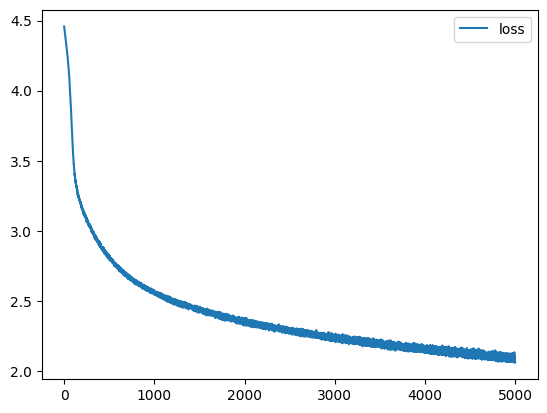

In [174]:
history = []
epochs = 5000

model.train()
for i in range(epochs):
    batch_data = torch.tensor(next(generate_chunk()), dtype=torch.int64)

    batch_data = torch.tensor(next(generate_chunk()), dtype=torch.long)

    input_seq = batch_data[:, :-1]
    target_seq = batch_data[:, 1:]

    optim.zero_grad()

    outputs = rnn_loop(model, input_seq)

    outputs = outputs.reshape(-1, outputs.size(-1))
    targets = target_seq.reshape(-1)
    loss = loss_func(outputs, targets)

    loss.backward()
    optim.step()

    history.append(loss.item())

    if (i+1) % 250 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [175]:
model.eval()

PoetryRNN(
  (embedding): Embedding(84, 100)
  (W_hh): Linear(in_features=100, out_features=100, bias=True)
  (W_xh): Linear(in_features=100, out_features=100, bias=True)
  (tanh): Tanh()
  (W_ho): Linear(in_features=100, out_features=84, bias=True)
)

In [176]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else: 
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    
    #feed the seed phrase, if any
    hidden = char_rnn.init_hidden(batch_size=1)
    for i in range(len(x_sequence[0]) - 1):
        _, hidden = char_rnn(x_sequence[:, i:i+1], hidden)
    
    # your code here
    for _ in range(max_length - len(x_sequence[0]) + 1):
        output, hidden = char_rnn(x_sequence[:, -1:], hidden)
        p = F.softmax(output / temperature, dim=-1).squeeze().data.numpy()
        next_idx = np.random.choice(num_tokens, p=p)
        next_idx = torch.tensor([[next_idx]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_idx], dim=1)
    
    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [177]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правило мна так обегись,
гов весель прозирать заменит
и закак.



ixii

так ной:
то в уминур ей к субать.



xxi горов,
моей рожнно гразоя;
она и плеть пображда,
помасть, чуюм.



xv

бы в доса ж гочель как бражда постобу веновой вседой не клекленье,
небусовал я льшит неблистинустью дума,
она когда подругного брагвассный,
плобкавиттожалей.



xxxi

заслели десе любражала, своживый без мой чил местивы, ложельбованил;
и доложенье мано…
когорьки родь он свы нетор
знуменный в


In [181]:
class PoetryTorchRNN(nn.Module):
    def __init__(self, num_tokens, hidden_size=100):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_tokens, hidden_size)  
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True) 
        self.decoder = nn.Linear(hidden_size, num_tokens)  

    def forward(self, X, h):
        embed = self.embedding(X)  
        output, h_new = self.rnn(
            embed, h
        )  
        logits = self.decoder(output)  
        return logits, h_new

    def init_hidden(self, batch_size, device="cpu"):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

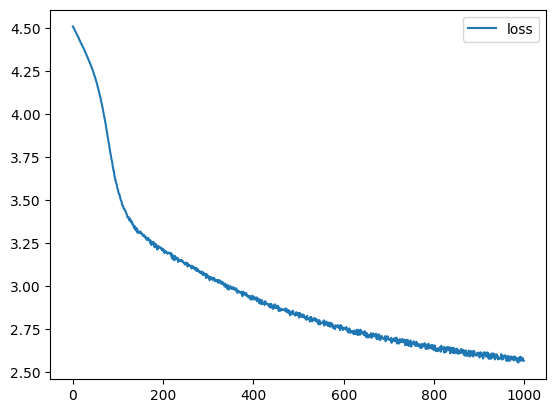

In [182]:
model = PoetryTorchRNN(num_tokens=len(tokens), hidden_size=100).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_idx["<sos>"])

history = []
epochs = 1000

model.train()
for i in range(epochs):
    batch_data = torch.tensor(next(generate_chunk()), dtype=torch.long).to(device)

    input_seq = batch_data[:, :-1]  
    target_seq = batch_data[:, 1:]  

    optim.zero_grad()

    hidden = model.init_hidden(batch_size=batch_data.size(0), device=device)
    outputs, _ = model(input_seq, hidden)
    outputs = outputs.reshape(
        -1, outputs.size(-1)
    )  
    targets = target_seq.reshape(-1)  

    loss = loss_func(outputs, targets)

    loss.backward()
    optim.step()

    history.append(loss.item())

    if (i + 1) % 250 == 0:
        clear_output(True)
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()

In [183]:
def generate_sample(
    char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device
):
    if seed_phrase is not None:
        x_sequence = [token_to_idx["<sos>"]] + [
            token_to_idx[token] for token in seed_phrase
        ]
    else:
        x_sequence = [token_to_idx["<sos>"]]

    x_sequence = torch.tensor([x_sequence], dtype=torch.long).to(device)

    hidden = char_rnn.init_hidden(batch_size=1, device=device)

    for i in range(x_sequence.size(1) - 1):
        _, hidden = char_rnn(x_sequence[:, i : i + 1], hidden)

    for _ in range(max_length - x_sequence.size(1)):
        logits, hidden = char_rnn(x_sequence[:, -1:], hidden)
        probs = F.softmax(logits / temperature, dim=-1).squeeze().cpu().data.numpy()
        next_idx = np.random.choice(len(tokens), p=probs)
        next_idx = torch.tensor([[next_idx]], dtype=torch.long).to(device)
        x_sequence = torch.cat([x_sequence, next_idx], dim=1)

    return "".join([tokens[ix] for ix in x_sequence.squeeze().cpu().numpy()])

In [184]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.9))

<sos> мой дядя самых честных правил, нилинмюя а.ста ста ся нел.
xiii

xxx«»l
эxixe
илыпомое с бозтняморишат причизстотавьс бмаме мна всетну зтяла саслреше вевядет.ной и пыл кал естами нилья, ернок, рашь кавов енанив ла нка,
у пренно жал рустзввокотьвеская тано стветь тымыпо, но ньvет,т.ушт, жедет,.
ссуж
итьиннрыэ
бниши де же бедсе стелнавпальжильнорь
iела,
перасредав.
ть,

скови
ей ланены веной го ёовуть, вдивила и но нинуйд
не зроя сена.накивх одо в нем
пруз милье про,
(ги м лем прастону нарогоу  н


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [178]:
seed_phrase = ' мой дядя самых честных правил'

In [179]:
generated_phrases = [
    generate_sample(
        model,
        ' мой дядя самых честных правил',
        max_length=500,
        temperature=1.
    ).replace('<sos>', '')
    for _ in range(10)
]

In [180]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'
    

submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!